### Topic: H&M Personalized Fashion Recommendations

For this challenge you are given the purchase history of customers across time, along with supporting metadata. Your challenge is to predict what articles each customer will purchase in the 7-day period immediately after the training data ends. Customer who did not make any purchase during that time are excluded from the scoring.

In [64]:
## Imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
# import cudf

### Read data

- As the dataset is very large ~13 gigs we are using cudf on a gpu P100 provided by kaggle, cudf uses gpu clusters to effiiciently load chunks of dataframe into memory.
- We are also converting the article_id column to int32 type by defining appropriate types to variables reduces the space occupied by the dataframe.
- Only filtering by 2020 year as we are only interested in the most recent year. Also, removing unnecesaary column like sales_channel_id.

In [65]:
%%time
## Read data
transaction_data = pd.read_csv('transactions_train.csv')

CPU times: user 21.8 s, sys: 3.58 s, total: 25.4 s
Wall time: 26.6 s


In [66]:
def convert_hex_int(x):
    return int(x, 16)

In [67]:
transaction_data['customer_id'] = transaction_data['customer_id'].apply(lambda x: convert_hex_int(str(x)[-16:]))
# transaction_data['customer_id'] = transaction_data['customer_id'].str[-16:].str.hex_to_int.astype('int64')
transaction_data['article_id'] = transaction_data.article_id.astype('int32')
transaction_data.t_dat = pd.to_datetime(transaction_data.t_dat)
transaction_data = transaction_data[['t_dat','customer_id','article_id', 'price']]
print(transaction_data.shape)
transaction_data.head()

(31788324, 4)


,t_dat,customer_id,article_id,price
0,2018-09-20,18439897732908966680,663713001,0.050831
1,2018-09-20,18439897732908966680,541518023,0.030492
2,2018-09-20,10112112306570742978,505221004,0.015237
3,2018-09-20,10112112306570742978,685687003,0.016932
4,2018-09-20,10112112306570742978,685687004,0.016932


### Data Preprocess 
 
 - Converting t_dat column to datetime column so as to extract year, month and day into separate columns

In [68]:
## Data preprocess
transaction_data.loc[:,'t_dat'] = pd.to_datetime(transaction_data['t_dat'])
transaction_data.loc[:, 'year'] = transaction_data['t_dat'].dt.year
transaction_data.loc[:, 'month'] = transaction_data['t_dat'].dt.month
transaction_data.loc[:, 'day'] = transaction_data['t_dat'].dt.day
transaction_data.head()

,t_dat,customer_id,article_id,price,year,month,day
0,2018-09-20,18439897732908966680,663713001,0.050831,2018,9,20
1,2018-09-20,18439897732908966680,541518023,0.030492,2018,9,20
2,2018-09-20,10112112306570742978,505221004,0.015237,2018,9,20
3,2018-09-20,10112112306570742978,685687003,0.016932,2018,9,20
4,2018-09-20,10112112306570742978,685687004,0.016932,2018,9,20


Converting into parquet files as parquet files are faster to load into memory

In [69]:
# transaction_data.to_parquet('transaction_data_hm.pqt',index=False)

In [70]:
# transaction_data = pd.read_parquet("./transaction_data_hm.pqt")

### How many years data do we have?

Observation: Seems like we made lot more transaction in 2019 than the previous 2 years

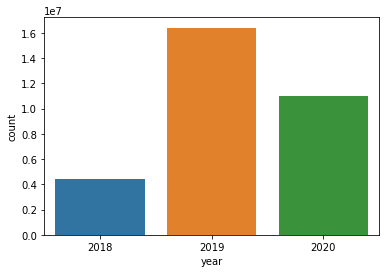

In [71]:
sns.countplot(x=transaction_data['year']);

### Do we have data for all the 12 months?

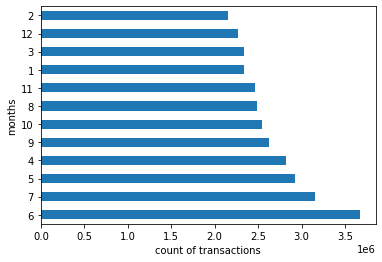

In [72]:
plt.xlabel("count of transactions")
plt.ylabel("months")
transaction_data.month.value_counts().plot(kind="barh");

### Is there a particular day which has highest transactions?

Observation: 

Usually more transaction happening during the month end except for the very last day of the month. Probably as people usually recieve their monthly salaries during the month end.

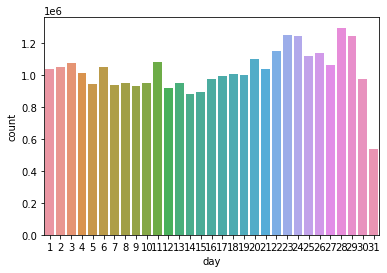

In [73]:
plt.ylabel("count of transactions")
plt.xlabel("days")
sns.countplot(x="day", data=transaction_data);

### Price fluctuation over the years for 2020

Obervations:

- We see a gradual increase from the start of the year and then a decline in transaction during the mid of the year and then a very steep increase by the end of the year.
- This might be due to the fact that there is thanksgiving and christmas holidays not to forget black friday sales during year end in whiich people buy the most.

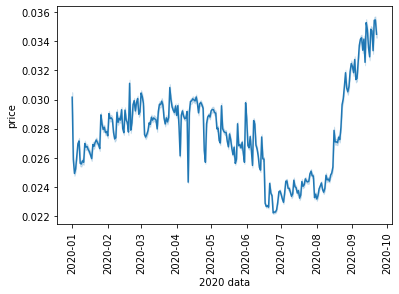

In [74]:
transactions_2020 =  transaction_data[transaction_data['year'] == 2020]
plt.xticks(rotation=90)
plt.xlabel("2020 data")
sns.lineplot(x="t_dat", y="price", data=transactions_2020);

### Lets analyse the latest year -- 2020!!

In [75]:
transaction_2020 = transaction_data[transaction_data['year'] == 2020]

### Which articles have the max price and the most cheap article?

In [76]:
max(transaction_2020.price), min(transaction_2020.price)

(0.5067796610169492, 3.389830508474576e-05)

### Most frequently bought articles

In [77]:
transactions_article_ids_value_counts = transaction_2020.article_id.value_counts()
transactions_article_ids_top_20 = transactions_article_ids_value_counts[:20].index.to_list()
articles_data = pd.read_csv("articles.csv", index_col = "article_id")
top_20_articles = articles_data.filter(items=transactions_article_ids_top_20, axis=0)
top_20_articles

,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
article_id,,,,,,,,,,,,,,,,,,,,,
706016001,706016,Jade HW Skinny Denim TRS,272,Trousers,Garment Lower body,1010016,Solid,9,Black,4,...,Trousers,D,Divided,2,Divided,53,Divided Collection,1009,Trousers,High-waisted jeans in washed superstretch deni...
610776002,610776,Tilly (1),255,T-shirt,Garment Upper body,1010016,Solid,9,Black,4,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,T-shirt in lightweight jersey with a rounded h...
751471001,751471,Pluto RW slacks (1),272,Trousers,Garment Lower body,1010016,Solid,9,Black,4,...,Trouser,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1009,Trousers,Ankle-length cigarette trousers in a stretch w...
759871002,759871,Tilda tank,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,...,EQ Divided Basics,D,Divided,2,Divided,80,Divided Complements Other,1002,Jersey Basic,"Cropped, fitted top in cotton jersey with narr..."
720125001,720125,SUPREME RW tights,273,Leggings/Tights,Garment Lower body,1010016,Solid,9,Black,4,...,Ladies Sport Bottoms,S,Sport,26,Sport,5,Ladies H&M Sport,1005,Jersey Fancy,Sports tights in fast-drying functional fabric...
372860001,372860,7p Basic Shaftless,302,Socks,Socks & Tights,1010016,Solid,9,Black,4,...,Shopbasket Socks,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,Fine-knit trainer socks in a soft cotton blend.
372860002,372860,7p Basic Shaftless,302,Socks,Socks & Tights,1010016,Solid,10,White,3,...,Shopbasket Socks,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,Fine-knit trainer socks in a soft cotton blend.
706016002,706016,Jade HW Skinny Denim TRS,272,Trousers,Garment Lower body,1010016,Solid,71,Light Blue,3,...,Trousers,D,Divided,2,Divided,53,Divided Collection,1009,Trousers,High-waisted jeans in washed superstretch deni...
841383002,841383,Vanessa 2-pack,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Fitted strappy top in soft organic cotton jersey.


### Seems like trousers are the most bought item!!

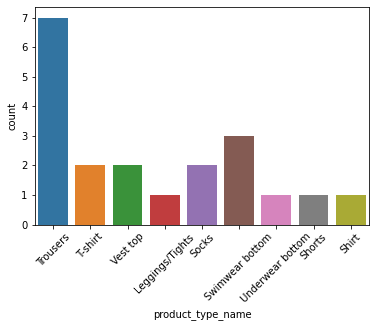

In [78]:
plt.xticks(rotation=45)
sns.countplot(x = top_20_articles.product_type_name);

### Which group dominates in terms of sales?

Seems like peeople buy much more lower body clothes than others, we can also see swimwear, socks and underwear in the top category.

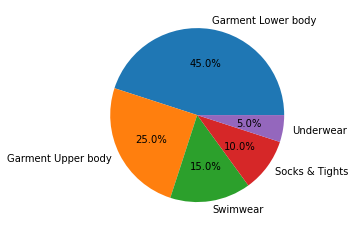

In [79]:
names, values = top_20_articles.product_group_name.value_counts().index, top_20_articles.product_group_name.value_counts().values
plt.pie(values, labels = names, autopct='%1.1f%%');

### How much sales did we make selling top 20 items?

In [80]:
count_top_20_transaction_articles = transactions_article_ids_value_counts[transactions_article_ids_top_20[:10]].values
price_top_20_transaction_articles = transaction_2020[transaction_2020.article_id.isin(transactions_article_ids_top_20)]
price_top_20_transaction_articles = price_top_20_transaction_articles.groupby('article_id').agg({"price": "sum"}).sort_values('price',ascending=False)

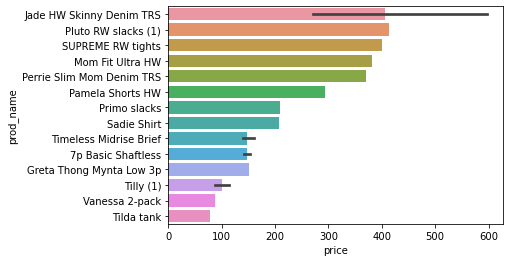

In [81]:
top_20_articles = price_top_20_transaction_articles.merge(articles_data, how = 'left', left_index = True, right_index = True)
sns.barplot(y = "prod_name", x = "price", data = top_20_articles);

### Lets have a look at some of these popular items

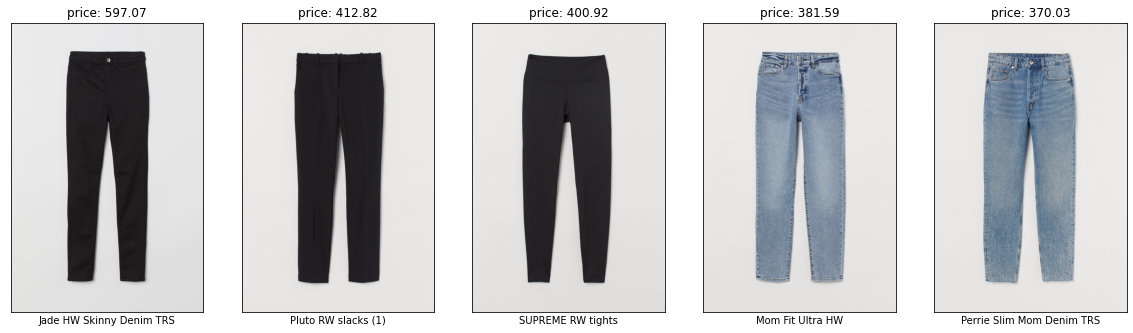

In [82]:
path = "images"
f, ax = plt.subplots(1, 5, figsize=(20,10))
i = 0
for idx, data in top_20_articles[:5].iterrows():
    file_name = "0" + str(idx) + ".jpg"
    dir_name = "0" + str(idx)[:2]
    image = mpimg.imread(path + "/" + dir_name + "/" + file_name)
    ax[i].imshow(image)
    ax[i].set_title(f'price: {data.price:.2f}')
    ax[i].set_xticks([], [])
    ax[i].set_yticks([], [])
    ax[i].grid(False)
    ax[i].set_xlabel(data['prod_name'], fontsize=10)
    i += 1
plt.show()

### Items purchased together by customers?

In [83]:
%%time
customers_data = pd.read_csv("customers.csv")
customers_data['customer_id'] = customers_data['customer_id'].apply(lambda x: convert_hex_int(str(x)[-16:]))
articles_data = pd.read_csv("articles.csv")
transactions_data_2020 = transaction_data[(transaction_data['year'] == 2020) & (transaction_data['month'] > 6) & (transaction_data['day'] > 20)]
transactions_customers_all_articles = transactions_data_2020.groupby('customer_id')['article_id'].unique().reset_index()

CPU times: user 13.7 s, sys: 2.06 s, total: 15.8 s
Wall time: 14.5 s


In [84]:
transactions_customers_all_articles.head()

,customer_id,article_id
0,28847241659200,"[887770001, 760084003]"
1,116809474287335,"[915529003, 935858001, 806131001, 873217004, 8..."
2,200292573348128,"[456163060, 847811001, 784332002, 863570003, 8..."
3,248294615847351,"[720504008, 471714002, 878987003, 337991001]"
4,272412481300040,"[885077001, 850176003, 875803001, 892970003, 8..."


In [58]:
data['article_id']

array([723469001], dtype=int32)

Articles that customers purchased together in single transaction: 
Customer id 28847241659200


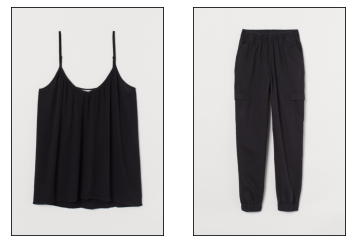

Customer id 116809474287335


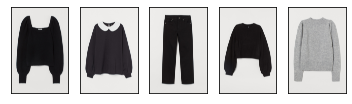

Customer id 200292573348128


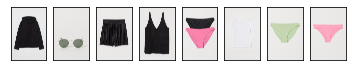

Customer id 248294615847351


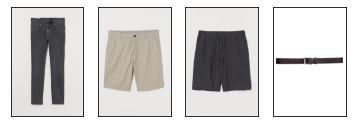

Customer id 272412481300040


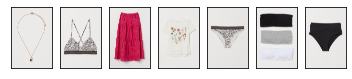

In [85]:
print("Articles that customers purchased together in single transaction: ")
for _, data in transactions_customers_all_articles.head(5).iterrows():
    print("Customer id", data['customer_id'])
    f, ax = plt.subplots(1, len(data['article_id']), figsize=(6, 6))
    path = "images"
    for i, article in enumerate(data['article_id']):
        file_name = "0" + str(article) + ".jpg"
        dir_name = "0" + str(article)[:2]
        image = mpimg.imread(path + "/" + dir_name + "/" + file_name)
        ax[i].imshow(image)
        
        ax[i].set_xticks([], [])
        ax[i].set_yticks([], [])
        ax[i].grid(False)
        i += 1
    plt.show()

### Can we summarise the customers who purchase a lot?

In [86]:
top_customers_id = transaction_2020['customer_id'].value_counts().index.to_list()
top_10_customers = customers_data[customers_data['customer_id'].isin(top_customers_id[:10])]
top_10_customers

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
21280,10637531262446564208,1.0,1.0,ACTIVE,Regularly,49.0,f2255b8174265ec97c29c5e7f23ee8e1d31b3bbe5ae34d...
358421,18442606110317830291,1.0,1.0,ACTIVE,Regularly,43.0,d51efa32b54a5f8c64d41ca12e7daa059e9a99ee31990f...
394603,742206143892321423,NaN,NaN,ACTIVE,NONE,28.0,ab724d6cb2340bd9c5294fd7f2811349f6509a27a8bc5c...
554973,11002644017240390486,1.0,1.0,ACTIVE,Regularly,55.0,c2a77fe2ea57d47bda150b792d51c2bcb45dd5740644e4...
680471,2697331706436144899,1.0,1.0,ACTIVE,Regularly,33.0,2c170eef5d71c660d26538cc8ba016cf8a65274925d82a...
891429,3407358910964148684,1.0,1.0,ACTIVE,Regularly,61.0,c46e53a04e81a44fecaf0ec64ae353bfb3abc91f510e79...
969180,7398229172292340849,1.0,1.0,ACTIVE,Regularly,25.0,4acdec769091cb0bc94cfd3324843156dbc572a7281ae4...
976721,12416564893706204993,1.0,1.0,ACTIVE,Regularly,43.0,ca6a33d3e52bd841e4be573a123ae2bcff3e6af65cc67a...
1018839,5854009424779598107,NaN,NaN,ACTIVE,NONE,31.0,67851f0456e7070c20c713fe0f47eb15bcbf2a59d13b79...
1331591,4111181464026910813,1.0,1.0,ACTIVE,Regularly,43.0,466cffb5c47f5aca3980a54be38daf7561133511705f4e...
